# Setup

## Imports

In [16]:
# Basic Libraries
import pandas as pd
import numpy as np

# Visualization
import plotly.express as px
import matplotlib.pyplot as plt

# Machine Learning
from yellowbrick.cluster import KElbowVisualizer
from sklearn.cluster import KMeans

## Configurations and Functions

In [17]:
# Defining plot standard parameters
plt.rcParams.update({
    "axes.labelcolor": "#595959",
    "axes.facecolor": (0, 0, 0, 0),
    "axes.grid": False,
    "axes.labelpad": 6,
    "axes.spines.right": False,
    "axes.spines.top": False,
    "figure.figsize": (9.25, 2.5),
    "figure.facecolor": (0, 0, 0, 0),
    "figure.dpi": 100,
    "legend.edgecolor": "#D9D9D9",
    "legend.borderaxespad": 0,
    "legend.framealpha": None,
    "legend.fontsize": 10,
    "legend.loc": "upper right",
    "legend.title_fontsize": 9,
    "text.color": "#595959",
    "xtick.color": "#D9D9D9",
    "xtick.labelcolor": "#595959",
    "ytick.color": "#D9D9D9",
    "ytick.labelcolor": "#595959"
})

# Ingesting Data

In [18]:
# List of report files
data_path = "../data/processed/rfm_standard.csv"

# Load data
df = pd.read_csv(data_path)

# Applying K-Means algorithm

In [19]:
%%capture
X = df.loc[:, ["recency", "frequency", "monetary"]]
optimal_k_value = KElbowVisualizer(estimator=KMeans(random_state=42), k=(2, 11), metric="distortion")
default_model = KMeans(n_clusters=optimal_k_value.fit(X).elbow_value_, random_state=42)
default_model.fit(X)
df = df.assign(rfm_default_clusters=default_model.labels_.astype(str))

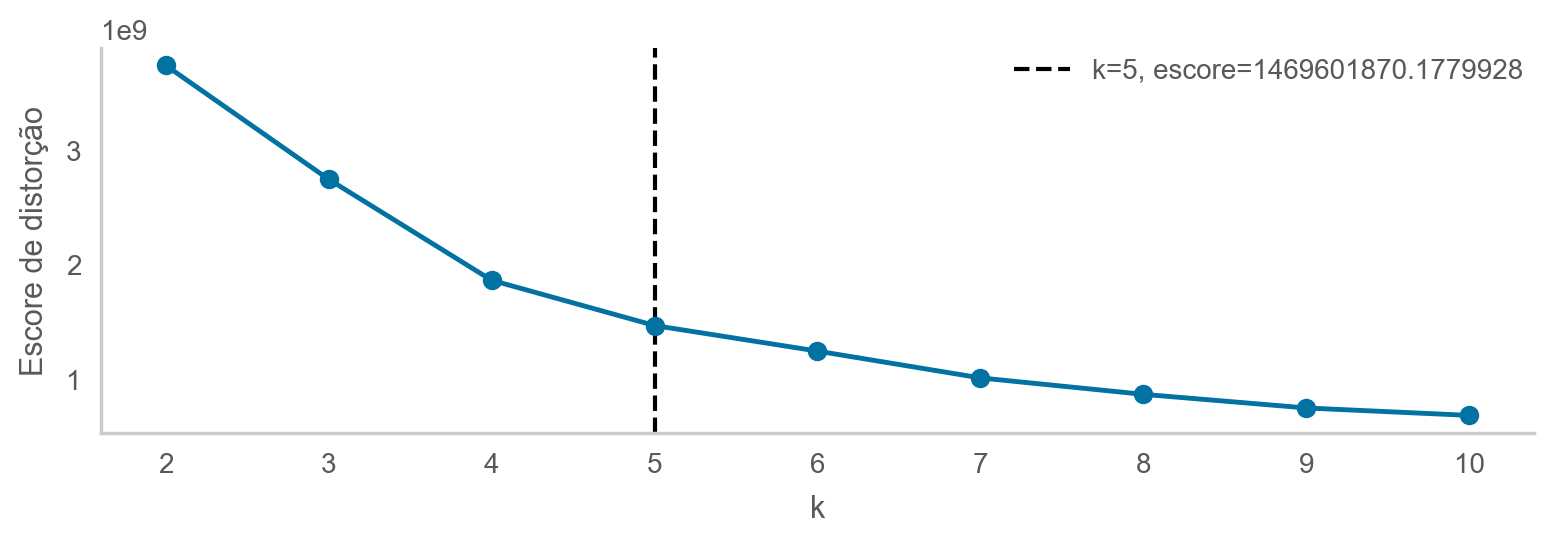

In [20]:
fig, ax = plt.subplots(dpi=200)
ax.plot(optimal_k_value.k_values_, optimal_k_value.k_scores_, marker='o', label='Distortion Score')
ax.set_xlabel("k")
ax.set_ylabel("Escore de distorção")
vline = ax.axvline(x=optimal_k_value.elbow_value_, color="black", linestyle='--', linewidth=1.5, zorder=1, label=f"k={optimal_k_value.elbow_value_}, escore={optimal_k_value.elbow_score_}")
plt.legend(handles=[vline]);

In [21]:
fig = px.scatter_3d(
    df, 
    x="recency", 
    y="frequency",
    z="monetary",
    color="rfm_default_clusters",
    opacity=0.8,
    category_orders={"rfm_default_clusters": ['0', '1', '2', '3', '4']}
)

fig.update_traces(marker=dict(size=4))

fig.update_layout(
    scene=dict(
        xaxis_title='Recência',
        yaxis_title='Frequência',
        zaxis_title='Monetário'
    ),
    legend_title_text='RFM',
    legend=dict(traceorder='normal'),
    height=800  # Increase the height of the chart
)
fig.for_each_trace(lambda t: t.update(name=str(int(t.name) + 1)))
fig.show()


## Notas

### Hipótese
1. A assimetria da distribuição de dados das três dimensões RFM (especialmente frequência e valor monetário) pode exigir uma técnica de transformação de distribuição de dados para o agrupamento.

### Evidências
1. A EDA realizada em [1.0-eda.ipynb](1.0-eda.ipynb) mostrou que a distribuição de dados é altamente enviesada, especialmente nas dimensões monetária e de recência. Esse enviesamento pode levar a resultados de agrupamento tendenciosos, onde certas dimensões dominam o processo.
2. A classificação RFM via o método de discretização por frequência igual em [2.0-rfm_default](2.0-rfm_default.ipynb) não conseguiu nem mesmo dividir a dimensão de frequência em 5 categorias, destacando o viés.
3. A análise visual realizada no gráfico de agrupamento revela que os clusters não estão bem definidos, e a dimensão de frequência não está sendo considerada no processo de agrupamento.

### Conclusões
1. Hipótese confirmada. Será testada uma técnica de transformação de distribuição de dados para melhorar os resultados de agrupamento. O valor do índice de distorção (também chamado SSE) do modelo atual é 46.142.

# Exporting Data

In [22]:
df.to_csv("../data/processed/rfm_kmeans.csv", index=False)

In [23]:
# Directly use K-means' built-in inertia_ attribute
kmeans_inertia = default_model.inertia_

# Validate by manual calculation (optional)
# Create DataFrame of K-Means centroids
centroids_df = pd.DataFrame(
    default_model.cluster_centers_,
    columns=['recency_centroid', 'frequency_centroid', 'monetary_centroid']
)
centroids_df['rfm_default_clusters'] = centroids_df.index.astype(str)  # Match cluster label type

# Merge centroids back into the original DataFrame
df_with_kmeans_centroids = df.merge(
    centroids_df,
    on='rfm_default_clusters',
    how='left'
)

# Manual calculation (should match default_model.inertia_)
data_kmeans = df_with_kmeans_centroids[['recency', 'frequency', 'monetary']].values
centroids_kmeans = df_with_kmeans_centroids[['recency_centroid', 'frequency_centroid', 'monetary_centroid']].values

kmeans_inertia_manual = ((data_kmeans - centroids_kmeans) ** 2).sum()

print("K-means Total Distortion (Inertia):", kmeans_inertia)

K-means Total Distortion (Inertia): 1469608674.9989119
